In [38]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [39]:
import numpy as np
import matplotlib.pyplot as plt
def set_up_images(X,y) :
  y_len = len(y)
  y_new = np.zeros((y_len,10))
  for i in range(y_len) : 
    y_new[i,y[i]] = 1
  # np.transpose
  X = X.reshape(y_len,3,32,32)
  # X = X.reshape(y_len,32,32,3)
  return X,y_new

def extract_train() :
  X_train = np.empty((50000, 3072), dtype='float32')
  y_train = [0]*50000
  for i in range(1,6):
    # /kaggle/input/cifar10-python/
    train_dict =  unpickle("cifar-10-batches-py/data_batch_"+ str(i))
    X = train_dict[b'data']
    y = train_dict[b'labels']
    X = X.astype('float32') / 255.0
    X_train[(i-1)*10000:i*10000, :] = X
    # print(X)
    y_train[(i-1)*10000:i*10000] = y
  X_train,y_train = set_up_images(X_train,y_train)
  return X_train,y_train

def extract_test() : 
  # /kaggle/input/cifar10-python/
  test_dict = unpickle("cifar-10-batches-py/test_batch")
  # print(test_dict.keys())
  X_test = test_dict[b'data'] #numpy array
  y_test = test_dict[b'labels'] #list type
  X_test = X_test.astype('float32') / 255.0
  X_test,y_test = set_up_images(X_test,y_test)
  return X_test,y_test

  
# a,b = extract_train()
# a = a[1]
# print(b[1])
# plt.imshow(a.transpose(1,2,0))
# plt.show()
# print(b)
# c,d = extract_test()
# print(d)
# a,b = set_up_images(a,b)
# print(a[0])
# print(b)


X_train - 50000,3,32,32
y_train - one hot encoded vector 50000, 10

In [40]:
import numpy as np

def index(x_shape, kernel_size):
   
    _, in_channels, height, width = x_shape
    
    out_height = ((height  - kernel_size) + 1)
    out_width = ((width  - kernel_size) + 1)

    x_0 = np.tile(np.repeat(np.arange(kernel_size), kernel_size),in_channels).reshape(-1, 1)
    
    y_0 = np.tile(np.arange(kernel_size), kernel_size * in_channels).reshape(-1, 1)
    
    x_1, y_1 = np.meshgrid(np.arange(out_height), np.arange(out_width), indexing='ij')
    x_1 = x_1.flatten().reshape(1, -1)
    y_1 = y_1.flatten().reshape(1, -1)
    
    x = x_0 + x_1
    y = y_0 + y_1

    z = np.repeat(np.arange(in_channels), kernel_size * kernel_size).reshape(-1, 1)

    return (z, x, y)


def x2col(x, kernel_size):
    k, i, j = index(x.shape, kernel_size)
    x_2d = x[:, k, i, j]
    
    x_2d = x_2d.transpose(1, 2, 0).reshape(kernel_size * kernel_size * x.shape[1], -1)
    return x_2d


def col2x(x_2d, x_shape, kernel_size):
    
    batch_size, in_channels, height, width = x_shape
    x_new = np.zeros((batch_size, in_channels, height, width), dtype='float32')
    k, i, j = index(x_shape, kernel_size)
    x2d_reshaped = x_2d.reshape(in_channels * kernel_size * kernel_size, -1, batch_size).transpose(2, 0, 1)
    
    np.add.at(x_new, (slice(None), k, i, j), x2d_reshaped)
    return x_new



In [41]:
import numpy as np

class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        #using xavier initialisation
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * np.sqrt(2 / ((in_channels * kernel_size * kernel_size) + (out_channels * kernel_size * kernel_size)))
        self.bias = np.zeros((out_channels,1))
        self.t = 0

    def forward(self,X):
        
        
        batch_size, _, height, width = X.shape
        out_height = (height - self.kernel_size)  + 1
        out_width = (width - self.kernel_size) + 1

        X_col = x2col(X, self.kernel_size)
        W_col = self.weights.reshape(self.out_channels, -1)

       
        output = np.dot(W_col , X_col) + self.bias

        output = output.reshape(self.out_channels, out_height, out_width, batch_size).transpose(3, 0, 1, 2)
        
        self.cache = (X.shape, X_col)
        return output


    def backward(self,dLdy):
        self.t += 1 #for adam's optimiser
        x_shape, X_col = self.cache
        batch_size = x_shape[0]
        

        db = np.sum(dLdy, axis=(0, 2, 3)).reshape(self.out_channels, -1)
        # print(db.shape)
        

        dLdy_reshaped = dLdy.transpose(1, 2, 3, 0).reshape(self.out_channels, -1)
        
        dW = np.dot(dLdy_reshaped, X_col.T).reshape(self.weights.shape)
        

        W_reshape = self.weights.reshape(self.out_channels, -1)
        
        dX_col = np.dot(W_reshape.T,dLdy_reshaped)

        dX = col2x(dX_col, x_shape, self.kernel_size)

        dW /= batch_size
        db /= batch_size
        return dX, dW, db



In [42]:
import numpy as np
class MaxPool2D:
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
        self.cache = None

    def forward(self, X_train: np.ndarray) :
        batch_size, channels ,height, width, = X_train.shape
        out_height = (height - self.pool_size) // self.stride + 1
        out_width = (width - self.pool_size) // self.stride + 1
        output = np.zeros((batch_size, channels, out_height, out_width))
        self.cache = (X_train, out_height, out_width)
        for i in range(out_height):
            for j in range(out_width):
                output[:, :, i, j] = np.amax(
                    X_train[:, :, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size],
                    axis=(2, 3))
        return output

    def backward(self, dLdy: np.ndarray):
        X_train, out_height, out_width= self.cache
        
        dLdX = np.zeros_like(X_train)
        for i in range(out_height):
            for j in range(out_width):
                input_block = X_train[:, :, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size]
                ismax = (input_block == np.max(input_block, axis=(2,3), keepdims=True))
                dLdX[:,:, i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size] += ismax * (dLdy[:, :, i:i+1, j:j+1])
        
        return dLdX

# mp = MaxPool2D(2,2)
# b = mp.forward(a)
# # X,y = extract_train()
# # X,y = set_up_images(X,y)
# # conv = MaxPool2D(2,1)
# # # a = conv.forward(X[0:32])
# # b = conv.forward(a)
# print(b.shape)

# dldy = np.random.randn(32,32,15,15)
# bc = mp.backward(dldy)
# print(bc.shape)

In [43]:
import numpy as np
class Linear:
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        self.weights = np.random.randn(in_features, out_features) * np.sqrt(2 / (in_features + out_features)) #xavier initialisation
        self.bias = np.zeros(out_features)
        self.cache = None
        self.t = 0

    def forward(self, X_train: np.ndarray) -> np.ndarray:
        batch_size = X_train.shape[0]
        output = np.dot(X_train, self.weights)
        output = output + self.bias
        self.cache = X_train
        return output

    def backward(self, dLdy: np.ndarray) -> np.ndarray:
        self.t +=1
        X_train = self.cache
        batch_size = X_train.shape[0]
        dLdX = np.dot(dLdy, self.weights.T)
        dLdw = np.dot(X_train.T, dLdy)
        dLdb = np.sum(dLdy, axis=0)
        
        dLdb /= batch_size
        dLdw /= batch_size
        
        return dLdX,dLdw,dLdb




In [44]:
import numpy as np
class ReLU:
    def __init__(self):
        self.cache = None

    def forward(self, X_train: np.ndarray) -> np.ndarray:
        self.cache = X_train
        return np.maximum(0, X_train)

    def backward(self, dLdy: np.ndarray) -> np.ndarray:
        X_train = self.cache
        dLdX = np.multiply((X_train > 0), dLdy)

        return dLdX

In [45]:
class Softmax:
    def __init__(self):
        self.cache = None

    def forward(self, X_train: np.ndarray) -> np.ndarray:
        exp_X_train = np.exp(X_train)
        output = exp_X_train / np.sum(exp_X_train, axis=1, keepdims=True)
        self.cache = output
        return output

    def backward(self, dLdy: np.ndarray) -> np.ndarray:

        y = self.cache
        batch_size = y.shape[0]
        jacobian_matrices = np.stack([np.diag(y[i]) - np.outer(y[i], y[i]) for i in range(batch_size)])
        dLdX = np.einsum('ijk,ik->ij', jacobian_matrices, dLdy)
        return dLdX
        
    

In [46]:
def categorical_cross_entropy_loss(y_true, y_pred):
    
    batch_size = y_true.shape[0]
    epsilon = 1e-7
    loss = -np.sum(y_true * np.log(y_pred + epsilon),axis=1)
    loss = np.sum(loss) / batch_size
    
    return loss


def grad_categorical_cross_entropy_loss(y_true,y_pred):
    batch_size = y_true.shape[0]
    epsilon = 1e-7
    gradient = (-1 ) * (y_true / (y_pred)) #check if divided by batch_size
    return gradient

def accuracy(y_true, y_pred):
    
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    accuracy = np.mean(np.equal(y_true, y_pred).astype(float))
    return accuracy


In [47]:
import numpy as np

class Adam():
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.m_w = 0 
        self.v_w = 0
        self.m_b = 0 
        self.v_b = 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.lr = lr
        
    def step(self, t, w, b, dw, db):
        
        
        self.m_w = self.beta1*self.m_w + (1-self.beta1)*dw
        
        self.m_b = self.beta1*self.m_b + (1-self.beta1)*db

        self.v_w = self.beta2*self.v_w + (1-self.beta2)*(dw**2)
       
        self.v_b = self.beta2*self.v_b + (1-self.beta2)*(db**2)

       
        m_w_hat = self.m_w/(1-self.beta1**t)
        m_b_hat = self.m_b/(1-self.beta1**t)
        v_w_hat = self.v_w/(1-self.beta2**t)
        v_b_hat = self.v_b/(1-self.beta2**t)

        w -= self.lr*(m_w_hat/(np.sqrt(v_w_hat)+self.epsilon))
        b -= self.lr*(m_b_hat/(np.sqrt(v_b_hat)+self.epsilon))
        
        return w, b
    


In [48]:
import numpy as np
import time
class CNN:
    def __init__(self):
        
        self.conv1 = Conv2D(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = Conv2D(in_channels=32, out_channels=64, kernel_size=5)
        self.conv3 = Conv2D(in_channels=64, out_channels=64, kernel_size=3)
        
      
        self.pool1 = MaxPool2D(pool_size=2,stride=2)
        self.pool2 = MaxPool2D(pool_size=2,stride=2)
        
        
        self.fc1 = Linear(in_features=64*3*3, out_features=64)
        self.fc2 = Linear(in_features=64, out_features=10)
        
        
        self.reluconv1 = ReLU()
        self.reluconv2 = ReLU()
        self.reluconv3 = ReLU()
        self.relufc1 = ReLU()

        self.softmax = Softmax()
        self.adamfc1 = Adam()
        self.adamfc2 = Adam()
        self.adamconv1 = Adam()
        self.adamconv2 = Adam()
        self.adamconv3 = Adam()
        
    
    def forward(self, x):
       
        out = self.conv1.forward(x)
        
        out = self.reluconv1.forward(out)
        
        out = self.pool1.forward(out)
        
        
        out = self.conv2.forward(out)
       
        out = self.reluconv2.forward(out)
        
        out = self.pool2.forward(out)
        

        out = self.conv3.forward(out)
      
        out = self.reluconv3.forward(out)
       
        # Flatten output
        out = np.reshape(out,(out.shape[0],out.shape[1]*out.shape[2]*out.shape[3]))
        # print(f"f1b = {out.shape}")
        
        
        out = self.fc1.forward(out)
       
        out = self.relufc1.forward(out)
        
        out = self.fc2.forward(out)
        
        out = self.softmax.forward(out)
        
        return out
    
    def backward(self, grad_loss):
        
        grad_out = self.softmax.backward(grad_loss)
        
        grad_out,dldw,dldb = self.fc2.backward(grad_out)
        self.fc2.weights,self.fc2.bias = self.adamfc2.step(self.fc2.t ,self.fc2.weights,self.fc2.bias,dldw,dldb)
        

        grad_out = self.relufc1.backward(grad_out)
        
        grad_out,dldw,dldb = self.fc1.backward(grad_out)
        self.fc1.weights,self.fc1.bias = self.adamfc1.step(self.fc1.t,self.fc1.weights,self.fc1.bias,dldw,dldb)
      
      
        
        grad_out = grad_out.reshape(-1,64,3,3)
        
        
        grad_out = self.reluconv3.backward(grad_out)
        
        grad_out,dldw,dldb= self.conv3.backward(grad_out)
        self.conv3.weights,self.conv3.bias = self.adamconv3.step(self.conv3.t,self.conv3.weights,self.conv3.bias,dldw,dldb)
        

        grad_out = self.pool2.backward(grad_out)
        grad_out,dldw,dldb = self.conv2.backward(self.reluconv2.backward(grad_out))
        self.conv2.weights,self.conv2.bias = self.adamconv2.step(self.conv2.t,self.conv2.weights,self.conv2.bias,dldw,dldb)

        grad_out = self.pool1.backward(grad_out)

        grad_out,dldw,dldb = self.conv1.backward(self.reluconv1.backward(grad_out))
        self.conv1.weights,self.conv1.bias = self.adamconv1.step(self.conv1.t,self.conv1.weights,self.conv1.bias,dldw,dldb)


    def predict(self,X_test) : 
        tot = X_test.shape[0]
        output = np.zeros((tot,10))
        batch_size = 100
        for i in range(0,tot,batch_size):
            logits = self.forward(X_test[i : i + batch_size])
            output[i : i +batch_size] = logits
        return output
    def val_stats(self,X_test,y_test) : 
        tot = X_test.shape[0]
        batch_size = 100
        curr_loss = 0.0
        corr = 0
        for i in range(0,tot,batch_size):
            y_batch = y_test[i : i + batch_size]
            logits = self.forward(X_test[i : i + batch_size])
            loss = categorical_cross_entropy_loss(y_batch,logits)
            curr_loss += loss
            corr += accuracy(y_batch,logits) * batch_size
        curr_loss /= (tot / batch_size)
        acc = (100 * corr) / tot
        return curr_loss,acc

    def train(self,X_train, y_train, X_test, y_test, num_epochs, batch_size) : 
        train_loss = []
        val_losses = []
        val_acc = []
        for epoch in range(num_epochs):
            # shuffle the data
            # loop over the batches
            n = X_train.shape[0]
            permutation = np.random.permutation(n)
            X_train = X_train[permutation]
            y_train = y_train[permutation]
            epoch_train_loss = 0.0
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                logits = self.forward(X_batch)
                                
                loss = grad_categorical_cross_entropy_loss(y_batch,logits)
                
                self.backward(loss)
                act_loss = categorical_cross_entropy_loss(y_batch,logits)
                epoch_train_loss += act_loss
                # print(epoch,i/32)
                if((i / 32) % 100 == 99) : 
                    # act_loss = categorical_cross_entropy_loss(y_batch,logits)
                    print(f"Loss for - {epoch}, {i/32} is  {act_loss}")
            

            epoch_train_loss /= (n / batch_size)
            train_loss.append(epoch_train_loss)

            val_loss,acc = self.val_stats(X_test,y_test)
            val_losses.append(val_loss)
            val_acc.append(acc)
            
        return train_loss,val_losses,val_acc


    

In [49]:
X_train,y_train = extract_train()
X_test,y_test = extract_test()
model = CNN()
t_loss,v_loss,v_acc = model.train(X_train[:15000],y_train[:15000],X_test[:5000],y_test[:5000],20,32)




Loss for - 0, 99.0 is  1.8851980751669024
Loss for - 0, 199.0 is  1.47741520953433
Loss for - 0, 299.0 is  1.7490143840907346
Loss for - 0, 399.0 is  1.3078969107026492
Loss for - 1, 99.0 is  1.32462904695988
Loss for - 1, 199.0 is  1.4433556157022722
Loss for - 1, 299.0 is  1.374560090913903
Loss for - 1, 399.0 is  1.2874941581263808
Loss for - 2, 99.0 is  1.4132845914045715
Loss for - 2, 199.0 is  1.3070241813343288
Loss for - 2, 299.0 is  1.6076392473548493
Loss for - 2, 399.0 is  1.495496122408642
Loss for - 3, 99.0 is  1.134192252472035
Loss for - 3, 199.0 is  1.2030371409189997
Loss for - 3, 299.0 is  1.7167531969979617
Loss for - 3, 399.0 is  1.317650289186097
Loss for - 4, 99.0 is  1.480535331757607
Loss for - 4, 199.0 is  1.225024131634985
Loss for - 4, 299.0 is  1.2304425787428106
Loss for - 4, 399.0 is  1.1982307345043717
Loss for - 5, 99.0 is  0.7597777340849812
Loss for - 5, 199.0 is  1.1909664311034738
Loss for - 5, 299.0 is  1.0613922795670228
Loss for - 5, 399.0 is  1.4

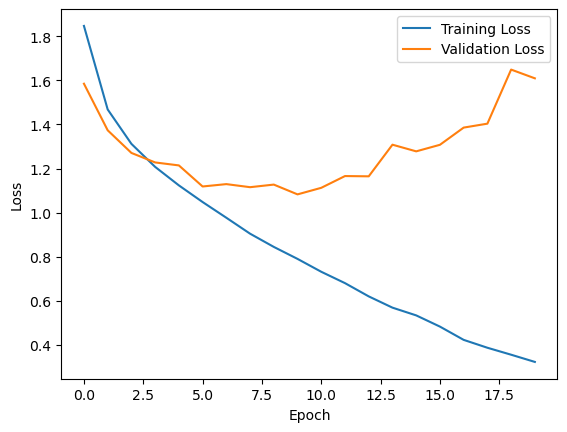

In [50]:
import matplotlib.pyplot as plt

plt.plot(range(20), t_loss, label='Training Loss')
plt.plot(range(20),v_loss,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss_3.png")





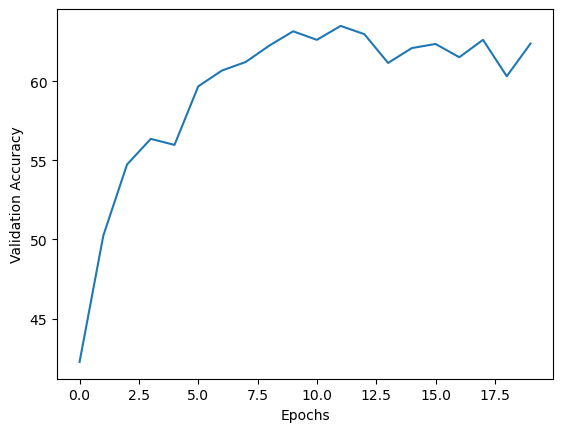

In [51]:
import matplotlib.pyplot as plt
plt.plot(range(20), v_acc)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
# plt.legend()
plt.savefig("acc_3.png")

Class-wise accuracy:  [63.52459016 79.40594059 46.09375    28.16901408 59.76331361 49.59016393
 76.37474542 67.47474747 80.95238095 72.12475634]


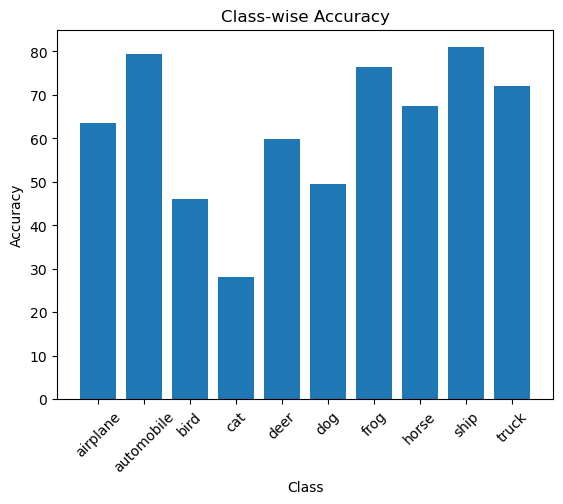

In [52]:
import matplotlib.pyplot as plt
correct = np.zeros(10)
total = np.zeros(10)

test_o = model.predict(X_test[:5000])
y_true = np.argmax(y_test[:5000], axis=1)
y_pred = np.argmax(test_o, axis=1)

for i in range(len(y_true)):
    true_label = y_true[i]
    pred_label = y_pred[i]
  
    if true_label == pred_label:
        correct[true_label] += 1

    total[true_label] += 1

class_acc = correct / total * 100
print('Class-wise accuracy: ', class_acc)


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_pos = np.arange(len(classes))


fig, ax = plt.subplots()
ax.bar(range(10), class_acc)
ax.set_xticks(range(10))
ax.set_xticklabels(classes, rotation=45)
ax.set_xlabel('Class')
ax.set_ylabel('Accuracy')
ax.set_title('Class-wise Accuracy')
plt.savefig("cw_3")



In [53]:
# output = model.forward(X_train[0:1000])
# print(accuracy(y_train[0:1000],output))